In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from utils.masks import extract_masks, binarize, resample_mask
from utils.images import normalize, resample_img
from utils.registration import est_lin_transf, apply_lin_transf, est_nl_transf, apply_nl_transf
from utils.plot_methods import plot_transf

In [2]:
def est_nl_transf_t(fix_img, fix_mask, mov_img):

    # initialize the registration
    reg_method = sitk.ImageRegistrationMethod()

    # create initial identity transformation.
    transform_to_displacement_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacement_field_filter.SetReferenceImage(fix_img)
    initial_transform = sitk.DisplacementFieldTransform(transform_to_displacement_field_filter.Execute(sitk.Transform()))

    #  regularization. 
    #  The update field refers to fluid regularization; the total field to elastic regularization.
    initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0)

    # set the initial transformation
    reg_method.SetInitialTransform(initial_transform)

    # use the function 'SetMetricAsDemons' to be able to perform Demons registration.
    # Provide a parameter (the intensity difference threshold) as input:
    # during the registration, intensities are considered to be equal if their difference is less than the given threshold.
    reg_method.SetMetricAsDemons(10)

    # evaluate the metrics only in the mask, if provided as an input
    reg_method.SetMetricFixedMask(fix_mask)

    # Multi-resolution framework
    reg_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    reg_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,0])

    # set a linear interpolator
    reg_method.SetInterpolator(sitk.sitkLinear)

    # set a gradient descent optimizer
    reg_method.SetOptimizerAsGradientDescent(learningRate=0.5, numberOfIterations=50, convergenceMinimumValue=1e-6,
                                             convergenceWindowSize=10)
    reg_method.SetOptimizerScalesFromPhysicalShift()

    # perform registration
    final_transform = reg_method.Execute(sitk.Cast(fix_img, sitk.sitkFloat32),
                                                  sitk.Cast(mov_img, sitk.sitkFloat32))

    print("--------")
    print("Demons registration:")
    print('Final metric value: {0}'.format(reg_method.GetMetricValue()))
    print("Optimizer stop condition: {0}".format(reg_method.GetOptimizerStopConditionDescription()))
    print("Number of iterations: {0}".format(reg_method.GetOptimizerIteration()))
    print("--------")    
    return final_transform

In [6]:
def demons_registration(fixed_image, moving_image, fixed_points = None, moving_points = None):
    
    registration_method = sitk.ImageRegistrationMethod()

    # Create initial identity transformation.
    transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
    transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
    # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
    initial_transform = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform()))
    
    # Regularization (update field - viscous, total field - elastic).
    initial_transform.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=2.0) 
    
    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsDemons(10) #intensities are equal if the difference is less than 10HU
        
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8,4,0])    

    registration_method.SetInterpolator(sitk.sitkLinear)
    # If you have time, run this code as is, otherwise switch to the gradient descent optimizer    
    #registration_method.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=20, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)        
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
        
    return registration_method.Execute(fixed_image, moving_image)  

In [37]:
fix_img = sitk.ReadImage('./data/common_40_image.nii.gz', sitk.sitkFloat32)
fix_mask = sitk.ReadImage('./data/common_40_mask_2.nii.gz', sitk.sitkFloat32)
fix_img_data = sitk.GetArrayFromImage(fix_img)
fix_mask_data = sitk.GetArrayFromImage(fix_mask)

In [38]:
mov_img = sitk.ReadImage('./data/g1_53_image.nii.gz',sitk.sitkFloat32)
mov_mask = sitk.ReadImage('./data/g1_53_mask_2.nii.gz',sitk.sitkFloat32)


In [39]:
fix_img = resample_img(fix_img, out_size=[512,512,205])
fix_mask = resample_mask(fix_mask, out_size=[512,512,205])
mov_img = resample_img(mov_img, out_size=[512,512,205])
mov_mask = resample_mask(mov_mask, out_size=[512,512,205])


In [40]:
lin_transf = est_lin_transf(fix_img, fix_mask, mov_img)


--------
Linear registration:
Final mean squares value: 132478.1526390246
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 23.
Number of iterations: 23
--------


In [41]:
aligned_img = apply_lin_transf(fix_img, mov_img, lin_transf)
aligned_mask = apply_lin_transf(fix_img, mov_mask, lin_transf)

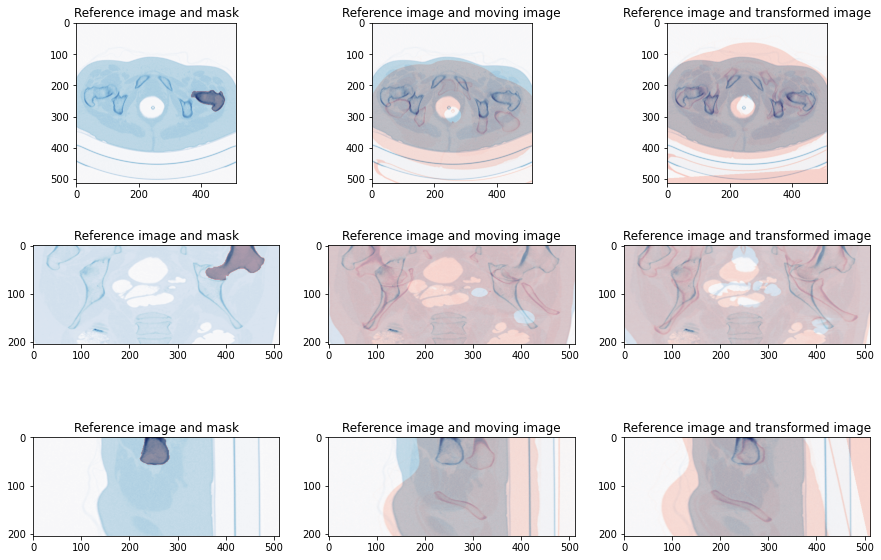

In [42]:
x,y,z = 40, 250, 450
plot_transf(fix_img, fix_mask, mov_img, aligned_img, x, y, z)

In [43]:
nl_transf = est_nl_transf(fix_img, fix_mask, aligned_img)


--------
Demons registration:
Final metric value: 465814.1087687107
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Number of iterations: 9
--------


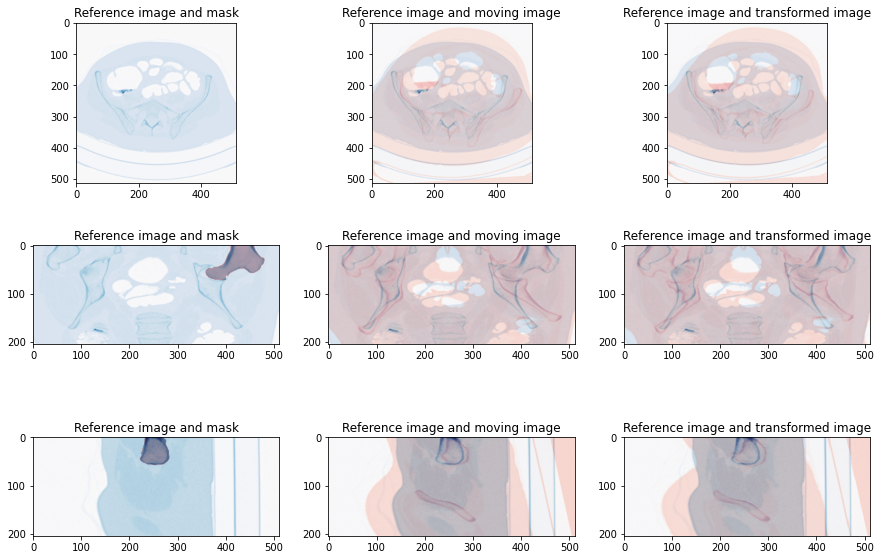

In [44]:
mov_img_resampled = apply_nl_transf(fix_img, aligned_img, nl_transf)
mov_mask_resampled = apply_nl_transf(fix_img, aligned_mask, nl_transf)

x,y,z = 140, 250, 450
plot_transf(fix_img, fix_mask, aligned_img, mov_img_resampled, x, y, z)